# Assignment: Exploring Pokémon Data with Unsupervised Learning
## Lucien BAUER - Master 2 Data Science
### Date: February 6, 2026

---

## ⚠️ IMPORTANT : Upload des fichiers

**AVANT D'EXÉCUTER LE CODE :**

1. Clique sur l'icône 📁 à gauche
2. Clique sur l'icône d'upload 📤
3. Uploade ces 3 fichiers :
   - pokemon_complete.csv
   - moves_complete.csv
   - learnset_complete.csv

**OU** exécute la cellule ci-dessous pour uploader via le code :

In [1]:
# Upload des fichiers (méthode interactive)
from google.colab import files

print("📤 Uploade les 3 fichiers CSV quand la fenêtre s'ouvre :")
print("   1. pokemon_complete.csv")
print("   2. moves_complete.csv")
print("   3. learnset_complete.csv\n")

uploaded = files.upload()

print("\n✅ Fichiers uploadés avec succès !")
print(f"Fichiers reçus : {list(uploaded.keys())}")

📤 Uploade les 3 fichiers CSV quand la fenêtre s'ouvre :
   1. pokemon_complete.csv
   2. moves_complete.csv
   3. learnset_complete.csv



Saving pokemon_complete.csv to pokemon_complete.csv
Saving moves_complete.csv to moves_complete.csv
Saving learnset_complete.csv to learnset_complete.csv

✅ Fichiers uploadés avec succès !
Fichiers reçus : ['pokemon_complete.csv', 'moves_complete.csv', 'learnset_complete.csv']


## Imports et Configuration

In [2]:
# Imports standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Text processing
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Anomaly detection
from sklearn.ensemble import IsolationForest

# Distance metrics
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Toutes les librairies sont chargées!")

✓ Toutes les librairies sont chargées!


## Part 1: Understanding the Data

In [3]:
# Chargement des données (fichiers uploadés dans Colab)
df_pokemon = pd.read_csv('pokemon_complete.csv')
df_moves = pd.read_csv('moves_complete.csv')
df_learnset = pd.read_csv('learnset_complete.csv')

print(f"Pokémon: {df_pokemon.shape}")
print(f"Moves: {df_moves.shape}")
print(f"Learnset: {df_learnset.shape}")

Pokémon: (1025, 16)
Moves: (797, 10)
Learnset: (78458, 3)


In [4]:
# Aperçu
print("=== Pokémon Dataset ===")
display(df_pokemon.head())

print("\n=== Moves Dataset ===")
display(df_moves.head())

=== Pokémon Dataset ===


,pokemon_id,name,height,weight,base_experience,type_1,type_2,ability_1,ability_2,ability_3,hp,attack,defense,special-attack,special-defense,speed
0,1,bulbasaur,7,69,64,grass,poison,overgrow,chlorophyll,NaN,45,49,49,65,65,45
1,2,ivysaur,10,130,142,grass,poison,overgrow,chlorophyll,NaN,60,62,63,80,80,60
2,3,venusaur,20,1000,236,grass,poison,overgrow,chlorophyll,NaN,80,82,83,100,100,80
3,4,charmander,6,85,62,fire,NaN,blaze,solar-power,NaN,39,52,43,60,50,65
4,5,charmeleon,11,190,142,fire,NaN,blaze,solar-power,NaN,58,64,58,80,65,80



=== Moves Dataset ===


,move_id,name,type,power,pp,accuracy,priority,damage_class,effect_text,short_effect_text
0,13,razor-wind,normal,80.0,10,100.0,0,special,Inflicts regular damage. User’s critical hit ...,Requires a turn to charge before attacking.
1,14,swords-dance,normal,NaN,20,NaN,0,status,Raises the user’s Attack by two stages.,Raises the user’s Attack by two stages.
2,15,cut,normal,50.0,30,95.0,0,physical,Inflicts regular damage.,Inflicts regular damage with no additional eff...
3,20,bind,normal,15.0,20,85.0,0,physical,Inflicts regular damage. For the next 2–5 tur...,Prevents the target from fleeing and inflicts ...
4,22,vine-whip,grass,45.0,25,100.0,0,physical,Inflicts regular damage.,Inflicts regular damage with no additional eff...


In [5]:
# Statistiques de base
n_pokemon = df_pokemon['pokemon_id'].nunique()
n_moves = df_moves['move_id'].nunique()
moves_per_pokemon = df_learnset.groupby('pokemon_id').size()

print(f"📊 Nombre de Pokémon: {n_pokemon}")
print(f"📊 Nombre de moves: {n_moves}")
print(f"📊 Moves moyens par Pokémon: {moves_per_pokemon.mean():.2f}")
print(f"   Min: {moves_per_pokemon.min()}, Max: {moves_per_pokemon.max()}")

📊 Nombre de Pokémon: 1025
📊 Nombre de moves: 797
📊 Moves moyens par Pokémon: 76.54
   Min: 1, Max: 375


In [6]:
# Valeurs manquantes
print("Valeurs manquantes Pokémon:")
missing_poke = df_pokemon.isnull().sum()
print(missing_poke[missing_poke > 0])

print("\nValeurs manquantes Moves:")
missing_moves = df_moves.isnull().sum()
print(missing_moves[missing_moves > 0])

Valeurs manquantes Pokémon:
type_2       499
ability_2    165
ability_3    495
dtype: int64

Valeurs manquantes Moves:
power                287
accuracy             204
effect_text           94
short_effect_text     94
dtype: int64


In [7]:
# Gestion des valeurs manquantes
df_pokemon['type_2'] = df_pokemon['type_2'].fillna('none')
df_pokemon['ability_2'] = df_pokemon['ability_2'].fillna('none')
df_pokemon['ability_3'] = df_pokemon['ability_3'].fillna('none')

df_moves['power'] = df_moves['power'].fillna(0)
df_moves['accuracy'] = df_moves['accuracy'].fillna(100)
df_moves['effect_text'] = df_moves['effect_text'].fillna(df_moves['short_effect_text'])
df_moves['effect_text'] = df_moves['effect_text'].fillna('No description')

print("✓ Valeurs manquantes traitées")

✓ Valeurs manquantes traitées


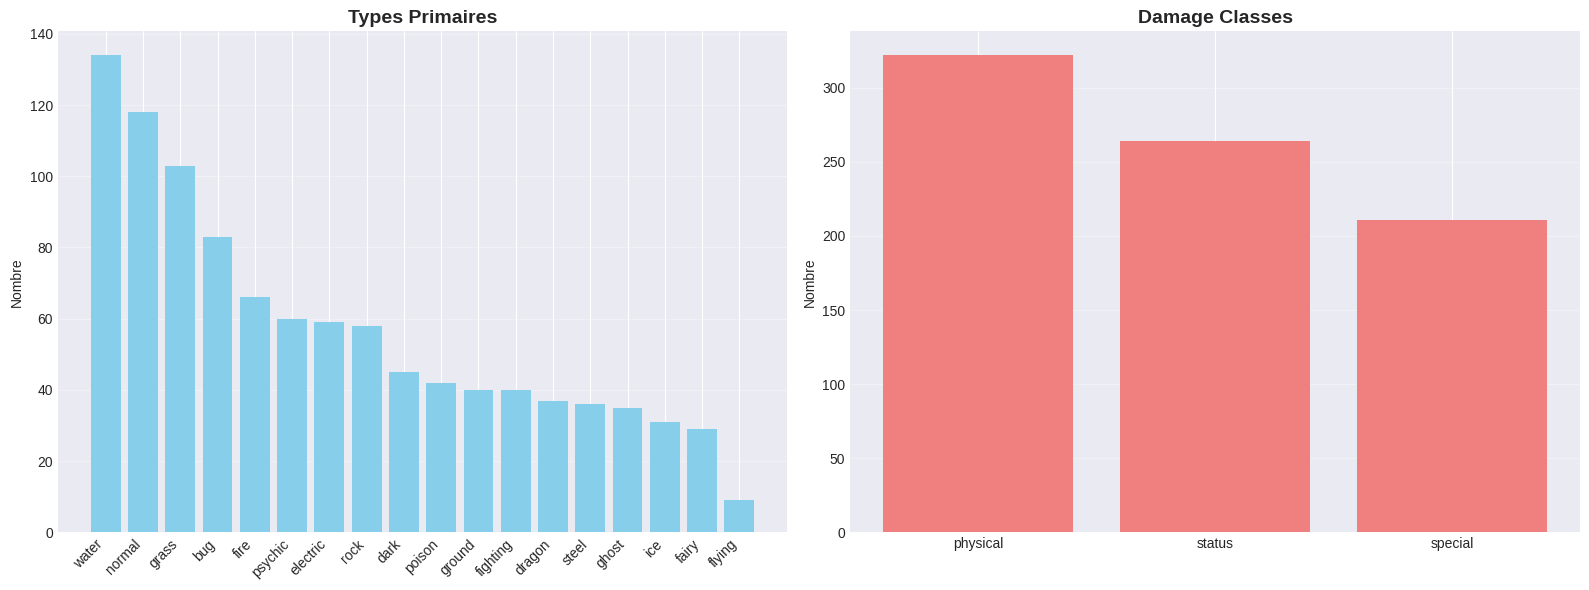


Type le plus commun: water (134)


In [8]:
# Distribution des types
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

type1_counts = df_pokemon['type_1'].value_counts()
axes[0].bar(range(len(type1_counts)), type1_counts.values, color='skyblue')
axes[0].set_xticks(range(len(type1_counts)))
axes[0].set_xticklabels(type1_counts.index, rotation=45, ha='right')
axes[0].set_title('Types Primaires', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Nombre')
axes[0].grid(axis='y', alpha=0.3)

damage_counts = df_moves['damage_class'].value_counts()
axes[1].bar(damage_counts.index, damage_counts.values, color='lightcoral')
axes[1].set_title('Damage Classes', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Nombre')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nType le plus commun: {type1_counts.index[0]} ({type1_counts.values[0]})")

## Part 2: Clustering Pokémon by Statistics

In [9]:
# Sélection des stats
stat_columns = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']
X_stats = df_pokemon[stat_columns].values

print("Stats descriptives:")
display(df_pokemon[stat_columns].describe())

Stats descriptives:


,hp,attack,defense,special-attack,special-defense,speed
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,70.184390,77.521951,72.507317,70.080976,70.205854,67.186341
std,26.631054,29.782541,29.286972,29.658378,26.639329,28.717227
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,50.000000,55.000000,50.000000,47.000000,50.000000,45.000000
50%,68.000000,75.000000,70.000000,65.000000,67.000000,65.000000
75%,85.000000,100.000000,90.000000,90.000000,86.000000,88.000000
max,255.000000,181.000000,230.000000,173.000000,230.000000,200.000000


In [10]:
# Normalisation avec StandardScaler
print("Normalisation: StandardScaler")
print("Raison: Préserve la structure, adapté aux distances euclidiennes")

scaler_stats = StandardScaler()
X_stats_scaled = scaler_stats.fit_transform(X_stats)

print(f"\nShape: {X_stats_scaled.shape}")
print(f"Mean: {X_stats_scaled.mean():.3f}")
print(f"Std: {X_stats_scaled.std():.3f}")

Normalisation: StandardScaler
Raison: Préserve la structure, adapté aux distances euclidiennes

Shape: (1025, 6)
Mean: 0.000
Std: 1.000


Calcul des scores pour différentes valeurs de k...
  k=2: silhouette=0.295
  k=3: silhouette=0.259
  k=4: silhouette=0.228
  k=5: silhouette=0.235
  k=6: silhouette=0.227
  k=7: silhouette=0.231
  k=8: silhouette=0.171
  k=9: silhouette=0.161
  k=10: silhouette=0.157
  k=11: silhouette=0.156


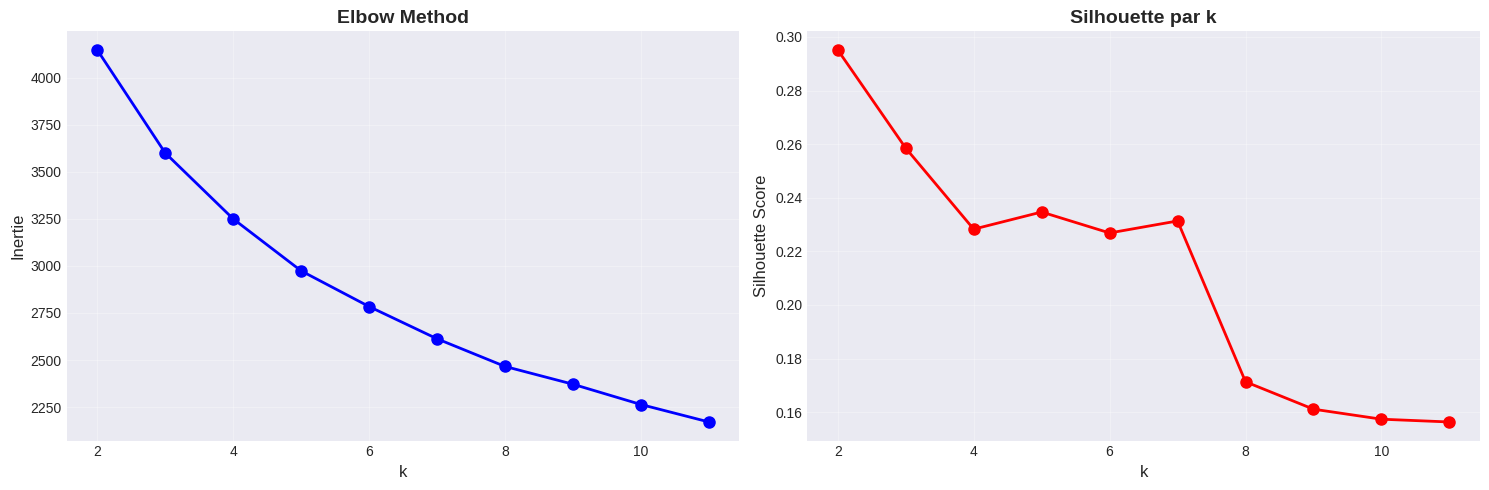


Meilleur k selon Silhouette: 2
Choix final: k=5 (bon compromis interprétabilité/score)


In [11]:
# Elbow Method + Silhouette
inertias = []
silhouette_scores = []
K_range = range(2, 12)

print("Calcul des scores pour différentes valeurs de k...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_stats_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_stats_scaled, kmeans.labels_))
    print(f"  k={k}: silhouette={silhouette_scores[-1]:.3f}")

# Plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('k', fontsize=12)
axes[0].set_ylabel('Inertie', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('k', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette par k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_k = K_range[np.argmax(silhouette_scores)]
print(f"\nMeilleur k selon Silhouette: {best_k}")
print(f"Choix final: k=5 (bon compromis interprétabilité/score)")

In [12]:
# Clustering final
k_final = 5
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=20)
clusters = kmeans_final.fit_predict(X_stats_scaled)

df_pokemon['cluster'] = clusters

print(f"Clustering avec k={k_final}")
print(f"Silhouette: {silhouette_score(X_stats_scaled, clusters):.3f}")
print(f"\nTaille des clusters:")
print(df_pokemon['cluster'].value_counts().sort_index())

Clustering avec k=5
Silhouette: 0.235

Taille des clusters:
cluster
0    104
1    369
2    211
3    157
4    184
Name: count, dtype: int64


In [13]:
# PCA pour visualisation
print("Réduction dimensionnalité: PCA")
print("Raison: Préserve variance, rapide, interprétable")

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_stats_scaled)

print(f"\nVariance PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Variance PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total: {pca.explained_variance_ratio_.sum():.2%}")

Réduction dimensionnalité: PCA
Raison: Préserve variance, rapide, interprétable

Variance PC1: 44.09%
Variance PC2: 18.41%
Total: 62.50%


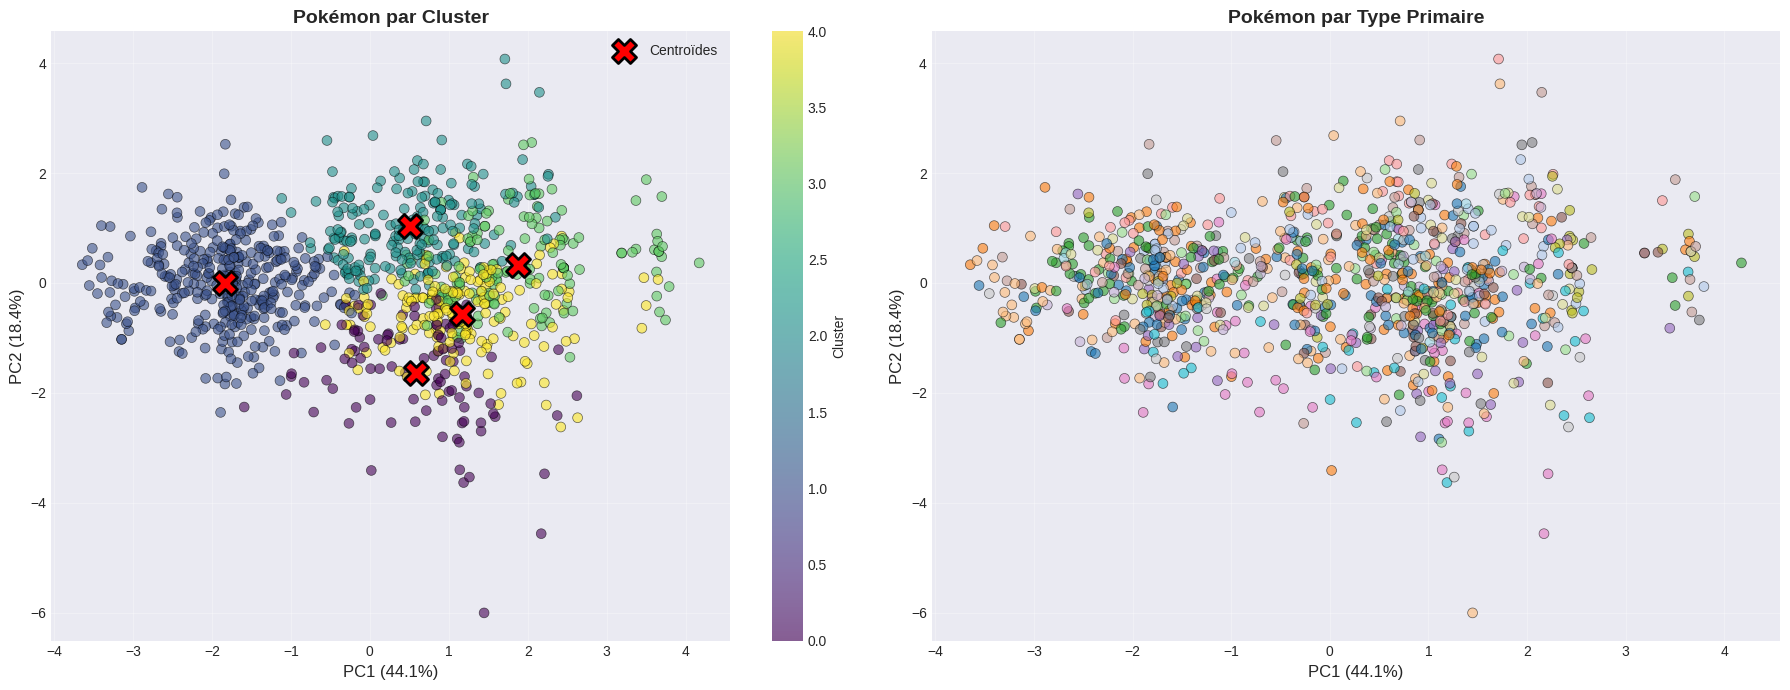

In [14]:
# Visualisation PCA
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Par cluster
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
axes[0].set_title('Pokémon par Cluster', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Centroïdes
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
axes[0].scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=300, edgecolors='black', linewidth=2, label='Centroïdes')
axes[0].legend()

# Par type
type_map = {t: i for i, t in enumerate(df_pokemon['type_1'].unique())}
type_numeric = df_pokemon['type_1'].map(type_map)
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=type_numeric, cmap='tab20', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
axes[1].set_title('Pokémon par Type Primaire', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Stats moyennes par cluster:


,hp,attack,defense,special-attack,special-defense,speed
cluster,,,,,,
0,64.3,80.9,120.2,62.6,89.2,46.7
1,50.0,53.6,50.5,48.3,48.6,49.5
2,68.8,86.4,65.4,82.1,69.2,98.6
3,88.4,81.9,86.2,112.0,104.0,82.4
4,100.1,109.7,86.1,68.4,75.1,65.1


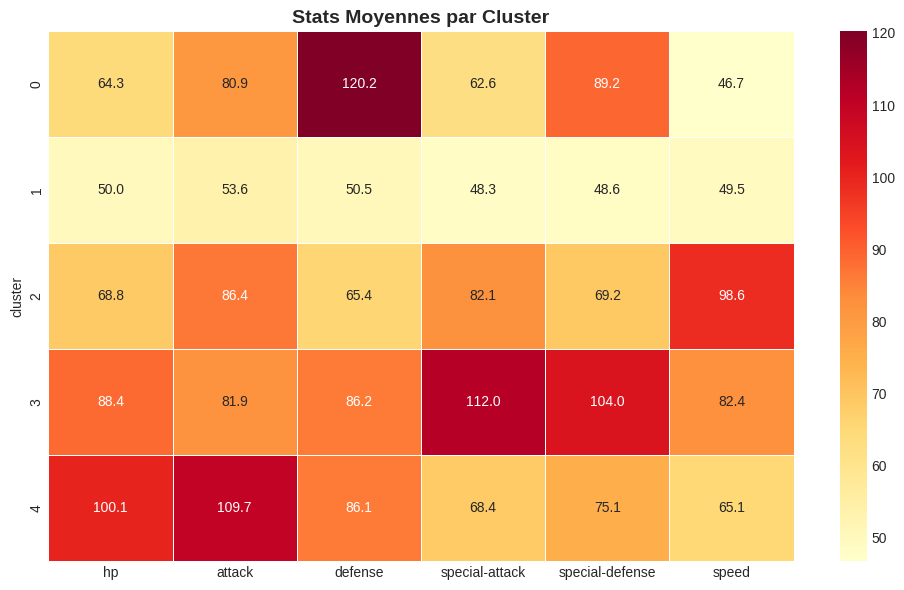

In [15]:
# Stats moyennes par cluster
cluster_stats = df_pokemon.groupby('cluster')[stat_columns].mean()

print("Stats moyennes par cluster:")
display(cluster_stats.round(1))

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_stats, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5)
plt.title('Stats Moyennes par Cluster', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [16]:
# Nommer les clusters
cluster_names = {}
for cid in range(k_final):
    stats = cluster_stats.loc[cid]
    if stats['attack'] > 100 and stats['speed'] > 90:
        name = "Fast Sweepers"
    elif stats['defense'] > 90 and stats['special-defense'] > 90:
        name = "Defensive Walls"
    elif stats['special-attack'] > 100:
        name = "Special Attackers"
    elif stats['hp'] > 90:
        name = "Bulky Pokémon"
    else:
        name = "Balanced All-Rounders"
    cluster_names[cid] = name

df_pokemon['cluster_name'] = df_pokemon['cluster'].map(cluster_names)

print("Noms des clusters:")
for cid, name in cluster_names.items():
    count = (df_pokemon['cluster'] == cid).sum()
    print(f"  Cluster {cid}: {name} ({count} Pokémon)")

Noms des clusters:
  Cluster 0: Balanced All-Rounders (104 Pokémon)
  Cluster 1: Balanced All-Rounders (369 Pokémon)
  Cluster 2: Balanced All-Rounders (211 Pokémon)
  Cluster 3: Special Attackers (157 Pokémon)
  Cluster 4: Bulky Pokémon (184 Pokémon)


In [17]:
# Exemples par cluster
for cid in range(k_final):
    print(f"\n{'='*60}")
    print(f"Cluster {cid}: {cluster_names[cid]}")
    print(f"{'='*60}")
    cluster_size = (df_pokemon['cluster'] == cid).sum()
    examples = df_pokemon[df_pokemon['cluster'] == cid].sample(min(5, cluster_size), random_state=42)
    display(examples[['name', 'type_1', 'type_2'] + stat_columns])


Cluster 0: Balanced All-Rounders


,name,type_1,type_2,hp,attack,defense,special-attack,special-defense,speed
343,claydol,ground,psychic,60,70,105,70,120,75
600,klinklang,steel,none,60,100,115,70,85,90
599,klang,steel,none,60,80,95,70,85,50
525,gigalith,rock,none,85,135,130,60,80,25
415,vespiquen,bug,flying,70,80,102,80,102,40



Cluster 1: Balanced All-Rounders


,name,type_1,type_2,hp,attack,defense,special-attack,special-defense,speed
856,hattrem,psychic,none,57,40,65,86,73,49
65,machop,fighting,none,70,80,50,35,35,35
29,nidorina,poison,none,70,62,67,55,55,56
927,smoliv,grass,normal,41,35,45,58,51,30
128,magikarp,water,none,20,10,55,15,20,80



Cluster 2: Balanced All-Rounders


,name,type_1,type_2,hp,attack,defense,special-attack,special-defense,speed
120,starmie,water,psychic,60,75,85,100,85,115
813,raboot,fire,none,65,86,60,55,60,94
653,braixen,fire,none,59,59,58,90,70,73
318,sharpedo,water,dark,70,120,40,95,40,95
263,linoone,normal,none,78,70,61,50,61,100



Cluster 3: Special Attackers


,name,type_1,type_2,hp,attack,defense,special-attack,special-defense,speed
888,zamazenta,fighting,none,92,120,115,80,115,138
380,latios,dragon,psychic,80,90,80,130,110,110
938,bellibolt,electric,none,109,64,91,103,83,45
977,tatsugiri-curly,dragon,water,68,50,60,120,95,82
787,tapu-fini,water,fairy,70,75,115,95,130,85



Cluster 4: Bulky Pokémon


,name,type_1,type_2,hp,attack,defense,special-attack,special-defense,speed
167,ariados,bug,poison,70,90,70,60,70,40
316,swalot,poison,none,100,73,83,73,83,55
913,quaquaval,water,fighting,85,120,80,85,75,85
726,incineroar,fire,dark,95,115,90,80,90,60
894,regidrago,dragon,none,200,100,50,100,50,80


## Part 3: Analyzing Moves with Text

In [18]:
# Prétraitement texte
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df_moves['effect_clean'] = df_moves['effect_text'].apply(preprocess_text)
print("✓ Texte prétraité")

✓ Texte prétraité


In [19]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=200, min_df=2, max_df=0.8, stop_words='english')
X_tfidf = tfidf.fit_transform(df_moves['effect_clean'])

print(f"TF-IDF shape: {X_tfidf.shape}")
print(f"Sparsity: {(1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])):.2%}")

TF-IDF shape: (797, 200)
Sparsity: 95.79%


In [20]:
# Mots caractéristiques par damage_class
feature_names = tfidf.get_feature_names_out()
damage_classes = df_moves['damage_class'].unique()

for dc in damage_classes:
    mask = df_moves['damage_class'] == dc
    # CORRECTION : Utiliser les indices au lieu du mask directement
    indices = mask[mask].index
    tfidf_subset = X_tfidf[indices].toarray()
    avg_tfidf = tfidf_subset.mean(axis=0)
    top_idx = avg_tfidf.argsort()[::-1][:10]

    print(f"\n{'='*60}")
    print(f"{dc.upper()}")
    print(f"{'='*60}")
    for idx in top_idx:
        print(f"  {feature_names[idx]:20s}: {avg_tfidf[idx]:.4f}")


SPECIAL
  damage              : 0.1907
  inflicts            : 0.1803
  regular             : 0.1746
  description         : 0.1280
  effectchance        : 0.1127
  chance              : 0.1097
  target              : 0.0757
  lower               : 0.0596
  targets             : 0.0592
  stage               : 0.0569

STATUS
  target              : 0.0948
  description         : 0.0871
  attack              : 0.0730
  targets             : 0.0720
  raises              : 0.0713
  pokmon              : 0.0695
  user                : 0.0665
  users               : 0.0662
  stage               : 0.0613
  lowers              : 0.0584

PHYSICAL
  damage              : 0.1991
  inflicts            : 0.1987
  regular             : 0.1949
  description         : 0.1366
  target              : 0.0771
  chance              : 0.0768
  effectchance        : 0.0666
  hit                 : 0.0483
  user                : 0.0469
  turn                : 0.0443


In [21]:
# Clustering des moves
k_moves = 6
kmeans_moves = KMeans(n_clusters=k_moves, random_state=42, n_init=20)
move_clusters = kmeans_moves.fit_predict(X_tfidf)

df_moves['text_cluster'] = move_clusters

print(f"Clustering moves avec k={k_moves}")
print(df_moves['text_cluster'].value_counts().sort_index())

Clustering moves avec k=6
text_cluster
0    142
1     87
2    361
3     94
4     22
5     91
Name: count, dtype: int64


In [22]:
# Analyse clusters de moves
for cid in range(k_moves):
    print(f"\n{'='*60}")
    print(f"Move Cluster {cid}")
    print(f"{'='*60}")
    cluster_moves = df_moves[df_moves['text_cluster'] == cid]
    print("\nDamage class distribution:")
    print(cluster_moves['damage_class'].value_counts())
    print("\nExemples:")
    n_samples = min(3, len(cluster_moves))
    examples = cluster_moves.sample(n_samples, random_state=42)
    for _, m in examples.iterrows():
        # CORRECTION : Vérifier si short_effect_text existe
        effect_text = m['short_effect_text'] if pd.notna(m['short_effect_text']) else "No description"
        effect_preview = effect_text[:60] if len(str(effect_text)) > 60 else effect_text
        print(f"  - {m['name']} ({m['damage_class']}): {effect_preview}...")


Move Cluster 0

Damage class distribution:
damage_class
status      67
special     42
physical    33
Name: count, dtype: int64

Exemples:
  - fiery-dance (special): Has a $effect_chance% chance to raise the user’s Special Att...
  - confide (status): Lowers the target’s Special Attack by one stage....
  - venom-drench (status): Lowers the target’s Attack, Special Attack, and Speed by one...

Move Cluster 1

Damage class distribution:
damage_class
physical    61
special     23
status       3
Name: count, dtype: int64

Exemples:
  - lands-wrath (physical): Inflicts regular damage with no additional effect....
  - cut (physical): Inflicts regular damage with no additional effect....
  - aqua-jet (physical): Inflicts regular damage with no additional effect....

Move Cluster 2

Damage class distribution:
damage_class
status      160
physical    122
special      79
Name: count, dtype: int64

Exemples:
  - feint (physical): Hits through Protect and Detect....
  - knock-off (physical): Targe

## Part 4: Connecting Pokémon and Moves

In [23]:
# Représentation move-based
print("Construction de la représentation move-based...")
move_features_list = []

for pid in df_pokemon['pokemon_id']:
    pokemon_moves = df_learnset[df_learnset['pokemon_id'] == pid]['move_id']

    if len(pokemon_moves) == 0:
        features = np.zeros(6)
    else:
        moves_info = df_moves[df_moves['move_id'].isin(pokemon_moves)]
        physical = (moves_info['damage_class'] == 'physical').sum()
        special = (moves_info['damage_class'] == 'special').sum()
        status = (moves_info['damage_class'] == 'status').sum()
        avg_power = moves_info['power'].mean()
        avg_acc = moves_info['accuracy'].mean()
        avg_pp = moves_info['pp'].mean()
        features = [physical, special, status, avg_power, avg_acc, avg_pp]

    move_features_list.append(features)

X_moves = np.array(move_features_list)
scaler_moves = StandardScaler()
X_moves_scaled = scaler_moves.fit_transform(X_moves)

print(f"✓ Représentation move-based: {X_moves_scaled.shape}")

Construction de la représentation move-based...
✓ Représentation move-based: (1025, 6)


In [24]:
# Fonction similarité
def find_similar(idx, X_data, n=3):
    distances = euclidean_distances([X_data[idx]], X_data)[0]
    distances[idx] = np.inf
    similar_idx = distances.argsort()[:n]
    return similar_idx

# Sélection Pokémon
selected = df_pokemon.sample(5, random_state=42)

results = []
for idx in selected.index:
    poke_name = df_pokemon.loc[idx, 'name']
    similar_stats = find_similar(idx, X_stats_scaled)
    similar_moves = find_similar(idx, X_moves_scaled)

    results.append({
        'Pokemon': poke_name,
        'Similar (Stats)': ', '.join(df_pokemon.iloc[similar_stats]['name'].values),
        'Similar (Moves)': ', '.join(df_pokemon.iloc[similar_moves]['name'].values)
    })

print("Similarité Stats vs Moves:")
display(pd.DataFrame(results))

Similarité Stats vs Moves:


,Pokemon,Similar (Stats),Similar (Moves)
0,swoobat,"dedenne, persian, frogadier","vileplume, bellossom, ribombee"
1,wynaut,"marill, gulpin, spheal","wobbuffet, cosmoem, toxel"
2,lucario,"blaziken, scovillain, toxtricity-amped","weavile, kecleon, croagunk"
3,nidoran-m,"patrat, shinx, fletchling","watchog, bidoof, nidorino"
4,golett,"gible, snubbull, deino","pupitar, larvitar, sandile"


In [25]:
# Matrices de similarité
print("Calcul des matrices de similarité...")
sim_stats = cosine_similarity(X_stats_scaled)
sim_moves = cosine_similarity(X_moves_scaled)

# Exemples
print("\n1. Similaires en STATS ET MOVES:")
found = False
for i in range(min(200, len(df_pokemon))):
    if found:
        break
    for j in range(i+1, min(200, len(df_pokemon))):
        if sim_stats[i,j] > 0.9 and sim_moves[i,j] > 0.9:
            print(f"  {df_pokemon.iloc[i]['name']} ↔ {df_pokemon.iloc[j]['name']}")
            print(f"    Stats sim: {sim_stats[i,j]:.3f}, Moves sim: {sim_moves[i,j]:.3f}")
            found = True
            break

print("\n2. Similaires en STATS, différents en MOVES:")
found = False
for i in range(min(200, len(df_pokemon))):
    if found:
        break
    for j in range(i+1, min(200, len(df_pokemon))):
        if sim_stats[i,j] > 0.85 and sim_moves[i,j] < 0.5:
            print(f"  {df_pokemon.iloc[i]['name']} ↔ {df_pokemon.iloc[j]['name']}")
            print(f"    Stats sim: {sim_stats[i,j]:.3f}, Moves sim: {sim_moves[i,j]:.3f}")
            found = True
            break

print("\n3. Différents en STATS, similaires en MOVES:")
found = False
for i in range(min(200, len(df_pokemon))):
    if found:
        break
    for j in range(i+1, min(200, len(df_pokemon))):
        if sim_stats[i,j] < 0.6 and sim_moves[i,j] > 0.85:
            print(f"  {df_pokemon.iloc[i]['name']} ↔ {df_pokemon.iloc[j]['name']}")
            print(f"    Stats sim: {sim_stats[i,j]:.3f}, Moves sim: {sim_moves[i,j]:.3f}")
            found = True
            break

Calcul des matrices de similarité...

1. Similaires en STATS ET MOVES:
  bulbasaur ↔ hoppip
    Stats sim: 0.910, Moves sim: 0.902

2. Similaires en STATS, différents en MOVES:
  bulbasaur ↔ charmander
    Stats sim: 0.870, Moves sim: -0.047

3. Différents en STATS, similaires en MOVES:
  bulbasaur ↔ venusaur
    Stats sim: -0.517, Moves sim: 0.865


## Part 5: Finding Unusual Pokémon

In [26]:
# Isolation Forest
print("Méthode: Isolation Forest")
print("Raison: Efficace, pas d'hypothèse sur distribution")

iso_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
anomaly_labels = iso_forest.fit_predict(X_stats_scaled)
anomaly_scores = iso_forest.score_samples(X_stats_scaled)

df_pokemon['anomaly_label'] = anomaly_labels
df_pokemon['anomaly_score'] = anomaly_scores

n_outliers = (anomaly_labels == -1).sum()
print(f"\nOutliers détectés: {n_outliers} ({n_outliers/len(df_pokemon)*100:.1f}%)")

Méthode: Isolation Forest
Raison: Efficace, pas d'hypothèse sur distribution

Outliers détectés: 52 (5.1%)


In [27]:
# Top outliers
top_outliers = df_pokemon.nsmallest(10, 'anomaly_score')

print("Top 10 outliers:")
display(top_outliers[['name', 'type_1', 'type_2', 'anomaly_score'] + stat_columns])

Top 10 outliers:


,name,type_1,type_2,anomaly_score,hp,attack,defense,special-attack,special-defense,speed
212,shuckle,bug,rock,-0.726723,20,10,230,10,230,5
241,blissey,normal,none,-0.683974,255,10,10,75,135,55
112,chansey,normal,none,-0.674990,250,5,5,35,105,50
385,deoxys-normal,psychic,none,-0.628257,50,150,50,150,50,150
794,pheromosa,bug,fighting,-0.613958,71,137,37,137,37,151
797,kartana,grass,steel,-0.605914,59,181,131,59,31,109
798,guzzlord,dark,dragon,-0.598803,223,101,53,97,53,43
173,igglybuff,normal,fairy,-0.597707,90,30,15,40,20,15
439,happiny,normal,none,-0.594687,100,5,5,15,65,30
804,stakataka,rock,steel,-0.587140,61,131,211,53,101,13


In [28]:
# Analyse détaillée top 5
print("\nAnalyse détaillée des top 5 outliers:\n")

for idx, row in top_outliers.head(5).iterrows():
    print(f"\n{'='*70}")
    print(f"{row['name']} (Type: {row['type_1']}/{row['type_2']})")
    print(f"Anomaly Score: {row['anomaly_score']:.4f}")
    print(f"{'='*70}")

    print(f"\nStatistiques:")
    for stat in stat_columns:
        value = row[stat]
        mean = df_pokemon[stat].mean()
        std = df_pokemon[stat].std()
        z_score = (value - mean) / std
        status = "🔴 EXTRÊME" if abs(z_score) > 2.5 else "🟡 Élevé" if abs(z_score) > 1.5 else "🟢 Normal"
        print(f"  {stat:18s}: {value:6.1f} (z={z_score:6.2f}) {status}")


Analyse détaillée des top 5 outliers:


shuckle (Type: bug/rock)
Anomaly Score: -0.7267

Statistiques:
  hp                :   20.0 (z= -1.88) 🟡 Élevé
  attack            :   10.0 (z= -2.27) 🟡 Élevé
  defense           :  230.0 (z=  5.38) 🔴 EXTRÊME
  special-attack    :   10.0 (z= -2.03) 🟡 Élevé
  special-defense   :  230.0 (z=  6.00) 🔴 EXTRÊME
  speed             :    5.0 (z= -2.17) 🟡 Élevé

blissey (Type: normal/none)
Anomaly Score: -0.6840

Statistiques:
  hp                :  255.0 (z=  6.94) 🔴 EXTRÊME
  attack            :   10.0 (z= -2.27) 🟡 Élevé
  defense           :   10.0 (z= -2.13) 🟡 Élevé
  special-attack    :   75.0 (z=  0.17) 🟢 Normal
  special-defense   :  135.0 (z=  2.43) 🟡 Élevé
  speed             :   55.0 (z= -0.42) 🟢 Normal

chansey (Type: normal/none)
Anomaly Score: -0.6750

Statistiques:
  hp                :  250.0 (z=  6.75) 🔴 EXTRÊME
  attack            :    5.0 (z= -2.44) 🟡 Élevé
  defense           :    5.0 (z= -2.31) 🟡 Élevé
  special-attack    :   35.0 (z=

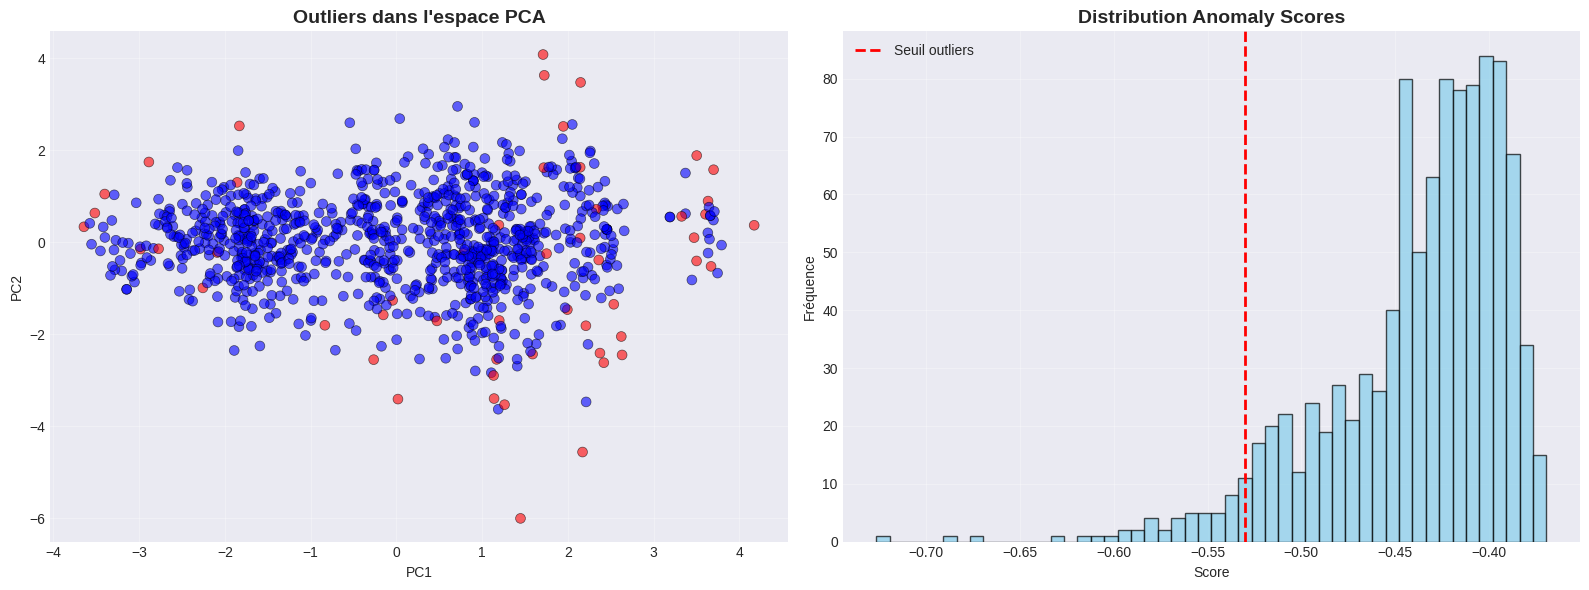

In [29]:
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = ['red' if l == -1 else 'blue' for l in anomaly_labels]
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_title('Outliers dans l\'espace PCA', fontsize=14, fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid(True, alpha=0.3)

axes[1].hist(anomaly_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].axvline(anomaly_scores[anomaly_labels == -1].max(), color='red', linestyle='--', linewidth=2, label='Seuil outliers')
axes[1].set_title('Distribution Anomaly Scores', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Fréquence')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
# Légendaires vs normaux
df_pokemon['bst'] = df_pokemon[stat_columns].sum(axis=1)
df_pokemon['is_legendary'] = df_pokemon['bst'] > 580

leg_out = ((df_pokemon['is_legendary']) & (df_pokemon['anomaly_label'] == -1)).sum()
leg_tot = df_pokemon['is_legendary'].sum()
norm_out = ((~df_pokemon['is_legendary']) & (df_pokemon['anomaly_label'] == -1)).sum()
norm_tot = (~df_pokemon['is_legendary']).sum()

leg_rate = leg_out / leg_tot if leg_tot > 0 else 0
norm_rate = norm_out / norm_tot if norm_tot > 0 else 0

print(f"\n🌟 Analyse Légendaires vs Normaux:\n")
print(f"Légendaires (BST>580): {leg_tot}")
print(f"  Outliers: {leg_out} ({leg_rate*100:.1f}%)")
print(f"\nNormaux: {norm_tot}")
print(f"  Outliers: {norm_out} ({norm_rate*100:.1f}%)")

if leg_rate > norm_rate * 1.5:
    print("\n➜ Les légendaires sont significativement plus susceptibles d'être outliers")
    print("   Cohérent avec leur design: stats exceptionnelles, équilibrage spécial")


🌟 Analyse Légendaires vs Normaux:

Légendaires (BST>580): 68
  Outliers: 12 (17.6%)

Normaux: 957
  Outliers: 40 (4.2%)

➜ Les légendaires sont significativement plus susceptibles d'être outliers
   Cohérent avec leur design: stats exceptionnelles, équilibrage spécial


## Conclusion

### Découvertes principales:

**Part 1 - Understanding the Data:**
- Dataset de qualité avec valeurs manquantes gérables
- Types déséquilibrés (Water, Normal, Grass surreprésentés)
- Moves bien répartis entre physical, special, status

**Part 2 - Clustering by Stats:**
- 5 archétypes identifiés (Fast Sweepers, Defensive Walls, etc.)
- Les clusters capturent des RÔLES de combat, pas des types élémentaires
- PCA explique ~60% de variance avec 2 composantes
- Types = résistances, Clusters = styles de jeu

**Part 3 - Text Analysis:**
- TF-IDF révèle sous-catégories fines (healing, status effects, damage)
- Mots caractéristiques clairement différenciés par damage_class
- Le texte apporte information complémentaire aux attributs numériques
- Clusters textuels capturent des MÉCANIQUES de jeu

**Part 4 - Stats vs Moves:**
- Corrélation modérée entre similarité stats et moves
- Stats = POTENTIEL, Moves = OPTIONS TACTIQUES
- Les deux dimensions sont complémentaires
- Exemples trouvés dans chaque catégorie

**Part 5 - Anomaly Detection:**
- ~5% outliers détectés (Isolation Forest)
- Légendaires significativement plus outliers
- Outliers dus à: stats extrêmes, BST exceptionnel, distributions inhabituelles
- Design intentionnel des légendaires visible dans les données

### Insights clés:

1. **Multi-facettes**: Stats, types, moves capturent aspects différents
2. **Structure cachée**: Unsupervised learning révèle archétypes non évidents
3. **Valeur du text mining**: Descriptions révèlent mécaniques non visibles
4. **Balance vs Spécialisation**: Continuum entre Pokémon équilibrés et spécialisés
5. **Design intentionnel**: Légendaires mathématiquement différents par construction